In [1]:
import numpy  as np
import pandas as pd
import inspect 

import scipy.integrate as integrate

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

from   invisible_cities.core.stat_functions  import poisson_sigma
from   invisible_cities.core .fit_functions  import gauss, expo
from   invisible_cities.icaro.hst_functions  import hist
from   invisible_cities.icaro.hst_functions  import gausstext

In [2]:
import matplotlib.pyplot as plt

### Useful parameters for plots
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 10, 7.5
plt.rcParams['figure.max_open_warning']= 0

In [3]:
def expo(x, tau):
        a0 = 1/(tau*(np.exp(-fit_range[0]/tau)-np.exp(-fit_range[1]/tau)))
        return a0*np.exp(-x/tau)
    
def exp(x, b, a):
    return a*np.exp(-b*x)

def expo_and_gauss(x, const, mean, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    
    return const * np.exp(-x*mean) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def double_expo_and_gauss(x, const1, mean1, const2, mean2, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    
    func = np.piecewise(x, [x<mu, x>=mu], [lambda x: (const1 * np.exp(-x*mean1) + const2 * np.exp(-x*mean2) +
                                           amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)), 
                                           lambda x :(const1 * np.exp(-x*mean1) + 
                                           amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.))])
    return func

def flat_expo_and_gauss(x, const1, mean1, amp, mu, sigma, const2):
    if sigma <= 0.:
        return np.inf
    
    func = np.piecewise(x, [x<mu, x>=mu], [lambda x: (const1 * np.exp(-x*mean1) + amp*(const2 +
                                           1./(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.))), 
                                           lambda x :(const1 * np.exp(-x*mean1) + 
                                           amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.))])
    return func

In [4]:
def get_tracks(filename, rmax, zrange, erange, cut_overlap=True, fMC=True):
    out_folder_name = '/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/summary/'
    try:
        df_tracks_one = pd.read_hdf(filename, 'Tracks')
    except:
        print(filename + 'Error')
    df_tracks_one.energy = df_tracks_one.energy * 1000.
    df_tracks_one.eblob1 = df_tracks_one.eblob1 * 1000.
    df_tracks_one.eblob2 = df_tracks_one.eblob2 * 1000.
    if fMC:
        df_tracks_one['signal'] = [e[0] if type(e) == np.ndarray else e for e in df_tracks_one.signal.values]
    
    one_track = df_tracks_one[df_tracks_one.numb_of_tracks >= 1]
    fid = one_track[(one_track.r_max < rmax) & (one_track.z_min > zrange[0]) & (one_track.z_max < zrange[1])]
    sep = fid[fid.ovlp_blob_energy == 0] if cut_overlap else fid
    roi = sep[(sep.energy > erange[0]) & (sep.energy < erange[1])]
    
    return roi

def get_seed_and_boundary(x, y, func, fixed_constant=False, fix_expo=False):
    ### Set parameters
    index0    = int(len(x)/6)
    index1    = int(5*len(x)/6)
    enrgPre   = x[index0]
    enrgPost  = x[index1]
    backgPre  = np.mean(y[index0-2:index0+2])
    backPost  = np.mean(y[index1-2:index1+2])
    meanSlope = np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
    constant  = backgPre/np.exp(-meanSlope * enrgPre)
    
    mu    = x[np.argmax(y)]
    sigma = np.sqrt(coref.weighted_mean_and_std(x, y)[1])#coref.weighted_mean_and_std(x, y)[1]
    amp   = np.max(y) * (2*np.pi)**.5 * sigma
    seed  = [constant, meanSlope, amp, x[np.argmax(y)], sigma, 0.0006627293091744915]
    boundary = [[0, 0, 0., 0, 0, 0.], [np.inf, 1., np.inf, np.inf, np.inf, 1]]

    if (fixed_constant is not False) & (len(inspect.getargspec(func).args)==7):
        seed[-1]        = fixed_constant
        boundary[0][-1] = fixed_constant * 0.999
        boundary[1][-1] = fixed_constant * 1.001
        
    if fix_expo:
        seed    [0]    =  0
        seed    [1]    =  0
        boundary[0][0] = -0.000000001
        boundary[1][0] =  0.000000001
        boundary[0][1] = -0.000000001
        boundary[1][1] =  0.000000001
        
    seed        = seed[:len(inspect.getargspec(func).args)-1]
    boundary[0] = boundary[0][:len(inspect.getargspec(func).args)-1]
    boundary[1] = boundary[1][:len(inspect.getargspec(func).args)-1]
    return seed, boundary

def plot_fit_histo(x, y, nbins, fit):
    y, x, _ = hist(data.energy, bins=nbins, range=erange, new_figure=False)
    mx = np.linspace(min(x), max(x), 1000)
    plt.xlabel('Track energy (keV)')
    plt.ylabel('Counts/bin')
    
    e_min_one, e_max_one = fit.values[3] - 3. * fit.values[4], fit.values[3] + 3. * fit.values[4]
    print(fit.values)
    print('Chi2 = {}'.format(fit.chi2))
    print('ROI signal: {0}--{1}, centered in {2}'.format(e_min_one, e_max_one, fit.values[3]))
    plt.axvline(e_min_one, ls='--', color='black')
    plt.axvline(e_max_one, ls='--', color='black')
    legend = gausstext(fit.values[2:5], fit.errors[2:5], 1592, 2458)
    plt.plot(mx, fit.fn(mx), 'r-', label=legend)

    expo1  = exp(mx, *fit.values[:2])
    expo2  = np.full(len(mx), fit.values[-1]) if len(inspect.getargspec(func)[0]) == 7 else np.full(len(mx), 0.)
    gauss1 = gauss(mx, *fit.values[2:5])
    
    plt.plot(mx, expo1, 'g-')
    plt.plot(mx, np.full(len(mx),expo2), 'y-')
    plt.plot(mx, expo1+expo2, 'b-')
                
    plt.legend(loc=1)    
       
def fit_data(data, nbins, erange, func, fixed_constant=False, fPlot=False, fix_expo=False):
    y, x = np.histogram(data.energy, bins=nbins, range=erange)
    x    = coref.shift_to_bin_centers(x)
    seed, boundary = get_seed_and_boundary(x, y, func, fixed_constant, fix_expo)
    sigma_y = poisson_sigma(y)
    f_one = fitf.fit(func, x, y, seed, fit_range=erange, sigma=sigma_y, bounds=boundary)
    if fPlot:
        plot_fit_histo(x, y, nbins, f_one)
    return f_one
    
def count_signal_bckg(fit, width):
    e_min_one, e_max_one = fit.values[3] - 3. * fit.values[4], fit.values[3] + 3. * fit.values[4]
    n_sig_0      = (integrate.quad(gauss, e_min_one, e_max_one, args=tuple(fit.values[2:5]))/(width))[0]
    n_bckg_0     = (integrate.quad(exp, e_min_one, e_max_one, args=(fit.values[1], fit.values[0]))/(width))[0]
    err_n_sig_0  = np.sqrt(n_sig_0)
    err_n_bckg_0 = np.sqrt(n_bckg_0)
    
    return [n_sig_0, err_n_sig_0], [n_bckg_0, err_n_bckg_0]

In [5]:
#### File production parameters
ecut     = 5e-3
qcut     = 10
it       = 60
vox_size = 5.
blobR    = 21

### Dict holding the results for each configuration
results_ns  = {}
results_nb  = {}
results_fit = {}
results_thr = {}
fixed_const = {}

### MonteCarlo data and gaussian

In [6]:
name   = 'MC_gauss'
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = False
func   = expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]
### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   .append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


`x0` is infeasible.
Dataset length = 131


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:370: RuntimeWarning: invalid value encountered in greater_equal
  return np.all((x >= lb) & (x <= ub))
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:370: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))


### MonteCarlo data and flat + gaussian with free const

In [7]:
name   = 'MC_flatgauss_free'
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = False
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]
### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


`x0` is infeasible.
Dataset length = 131


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


### MonteCarlo data and flat + gaussian with fixed const (using only signal events)

#### Find fixed value

Use only signal events to get an estimate of the flat value below the gaussian

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.57709998e-17 0.00000000e+00 5.84353153e+04 1.60250000e+03
 7.00700751e+00 7.93974330e-04]
Chi2 = 21.449126179990586
ROI signal: 1581.478977553007--1623.5210226065315, centered in 1602.5000000797693


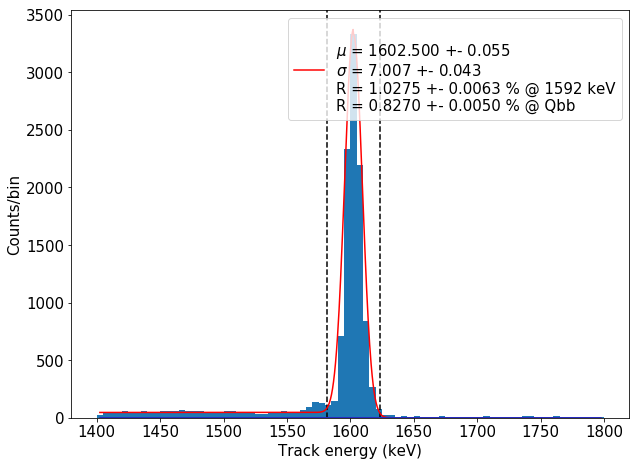

In [8]:
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = False
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data     = get_tracks(filename, r_max, zrange, erange)

data     = data[data.signal==1]
#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True, fix_expo=True)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

fixed_const['MC_signal'] = fit.values[-1]

In [9]:
name   = 'MC_flatgauss_fixed'
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = fixed_const['MC_signal']
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]

### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


`x0` is infeasible.
Dataset length = 131


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


### MonteCarlo data and flat + gaussian with fixed const (get constant at high efficiency cut ~380 keV)

#### Find fixed value

Use only distribution at high efficiency cut to get an estimate of the flat value below the gaussian

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.78108679e+01 2.69747940e-13 2.88514367e+04 1.60305956e+03
 6.09467142e+00 9.73587603e-04]
Chi2 = 3.2051053124248323
ROI signal: 1584.7755455292383--1621.343574078145, centered in 1603.0595598036916


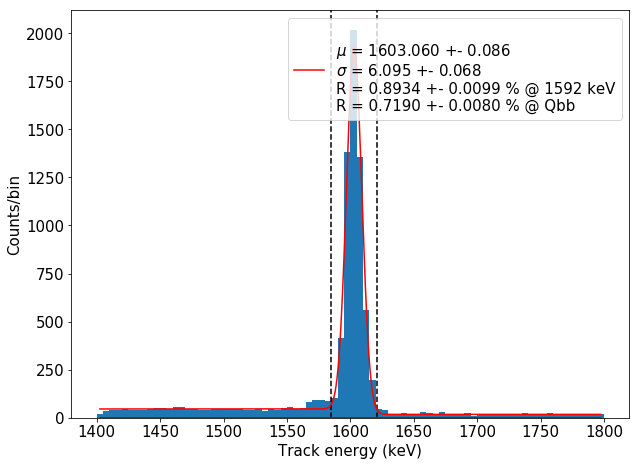

In [10]:
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = False
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data     = get_tracks(filename, r_max, zrange, erange)

name      = 'MC_flatgauss_free'
fom       = results_ns[name][:,0]/results_ns[name][0,0] / np.sqrt(results_nb[name][:,0]/(results_nb[name][0,0]))
threshold = results_thr[name][np.argmax(fom)]
data      = data[data.eblob2 > threshold]#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True, fix_expo=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

fixed_const['MC_cut'] = fit.values[-1]

In [11]:
name   = 'MC_flatgauss_fixed_cut'
r_max  = 180 #180
zrange = [20, 510]
erange = [1400, 1800]
nbins  = 80
fixed  = fixed_const['MC_cut']
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]

### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


`x0` is infeasible.
Dataset length = 131


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


### Results of MC

Text(0, 0.5, 'f.o.m')

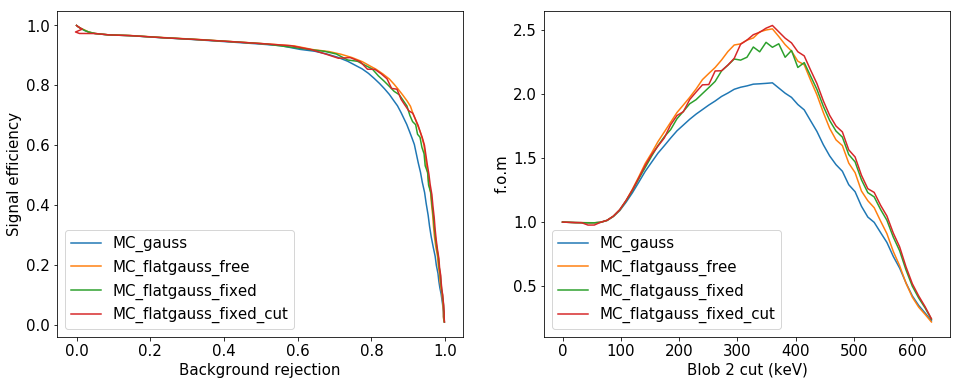

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name in results_nb.keys():
    fom  = results_ns[name][:,0]/results_ns[name][0,0] / np.sqrt(results_nb[name][:,0]/(results_nb[name][0,0]))
    ethr = results_thr[name]
    sel  = fom<10
    axes[0].plot((1-results_nb[name][:,0]/(results_nb[name][0,0]))[sel], (results_ns[name][:,0]/results_ns[name][0,0])[sel], label=name)
    axes[1].plot(ethr[sel], fom[sel], label=name)
axes[0].legend()
axes[0].set_xlabel('Background rejection')
axes[0].set_ylabel('Signal efficiency'   )

axes[1].legend()
axes[1].set_xlabel('Blob 2 cut (keV)')
axes[1].set_ylabel('f.o.m'           )

### Real data and gaussian

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.71448838e+03 1.37998382e-03 2.66805568e+04 1.66983013e+03
 7.30649741e+00]
Chi2 = 1.426232540036984
ROI signal: 1647.9106427066008--1691.7496271504247, centered in 1669.8301349285127


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


`x0` is infeasible.
Dataset length = 59


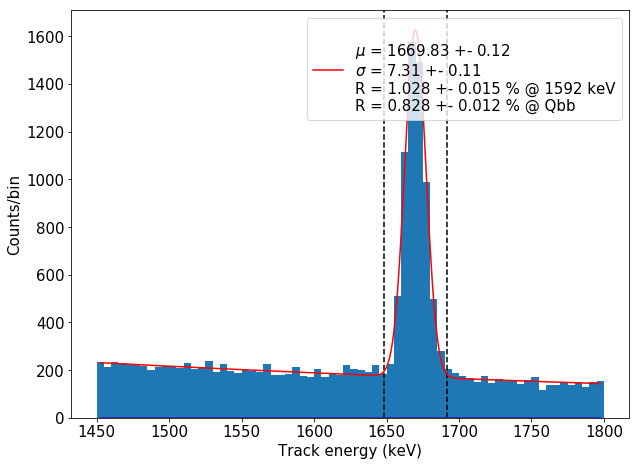

In [13]:
name   = 'Data_gauss'
r_max  = 180 #180
zrange = [20, 510]
erange = [1450, 1800]
nbins  = 70
fixed  = False
func   = expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/data/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange, fMC=False)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]
### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   .append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

### Real data and flat + gaussian with free const

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.45330872e+03 1.28835935e-03 2.66577761e+04 1.66986366e+03
 7.30296218e+00 1.96080877e-04]
Chi2 = 1.439139658873306
ROI signal: 1647.9547708263517--1691.7725438900889, centered in 1669.8636573582203


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


`x0` is infeasible.
Dataset length = 59


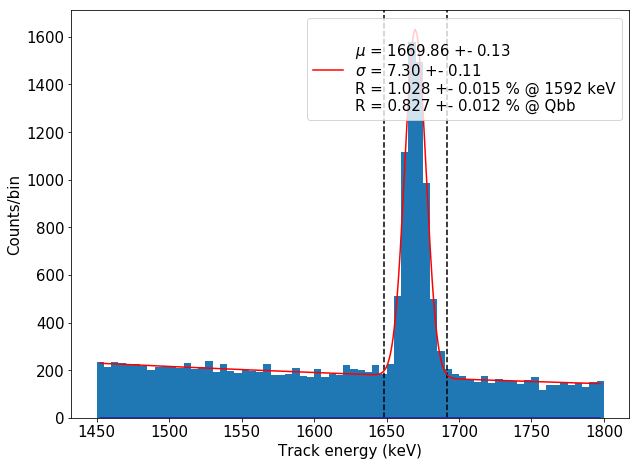

In [14]:
name   = 'Data_flatgauss_free'
r_max  = 180 #180
zrange = [20, 510]
erange = [1450, 1800]
nbins  = 70
fixed  = False
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/data/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange, fMC=False)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]
### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

### Real data and flat + gaussian with fixed const (using MC constant with only signal events)

#### Find fixed value

Use only signal events to get an estimate of the flat value below the gaussian

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[8.43481429e+02 9.85380393e-04 2.65455767e+04 1.66996481e+03
 7.29049368e+00 7.93180355e-04]
Chi2 = 1.5227599867439916
ROI signal: 1648.0933268532472--1691.8362889087252, centered in 1669.9648078809862


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


`x0` is infeasible.
Dataset length = 59


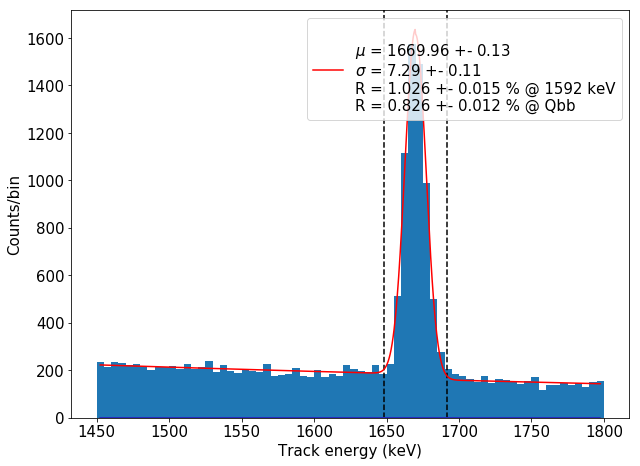

In [15]:
name   = 'Data_flatgauss_fixed_MC'
r_max  = 180 #180
zrange = [20, 510]
erange = [1450, 1800]
nbins  = 70
fixed  = fixed_const['MC_signal']
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/data/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange, fMC=False)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]

### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

### Real data and flat + gaussian with fixed const (get constant at high efficiency cut ~380 keV)

#### Find fixed value

Use only distribution at high efficiency cut to get an estimate of the flat value below the gaussian

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.84192228e+01 3.42305494e-04 1.55649124e+04 1.66999765e+03
 7.32186524e+00 5.78453427e-04]
Chi2 = 1.377538759572199
ROI signal: 1648.0320521813715--1691.9632436050497, centered in 1669.9976478932106


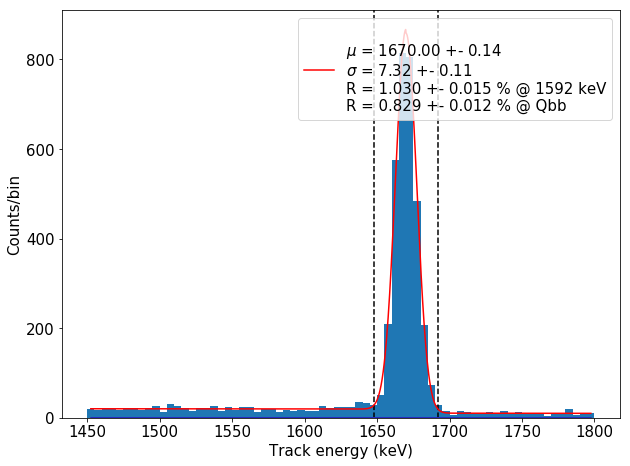

In [16]:
r_max  = 180 #180
zrange = [20, 510]
erange = [1450, 1800]
nbins  = 70
fixed  = False
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/data/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data     = get_tracks(filename, r_max, zrange, erange, fMC=False)

name      = 'Data_flatgauss_free'
fom       = results_ns[name][:,0]/results_ns[name][0,0] / np.sqrt(results_nb[name][:,0]/(results_nb[name][0,0]))
threshold = results_thr[name][np.argmax(fom)]
data      = data[data.eblob2 > threshold]#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True, fix_expo=False)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

fixed_const['Data_cut'] = fit.values[-1]

/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:71: Deprecatio

[1.21416800e+03 1.19855258e-03 2.66211228e+04 1.66993828e+03
 7.31096827e+00 5.77921885e-04]
Chi2 = 1.4918323713341148
ROI signal: 1648.0053730733982--1691.8711827181721, centered in 1669.9382778957852


/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/lior/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


`x0` is infeasible.
Dataset length = 59


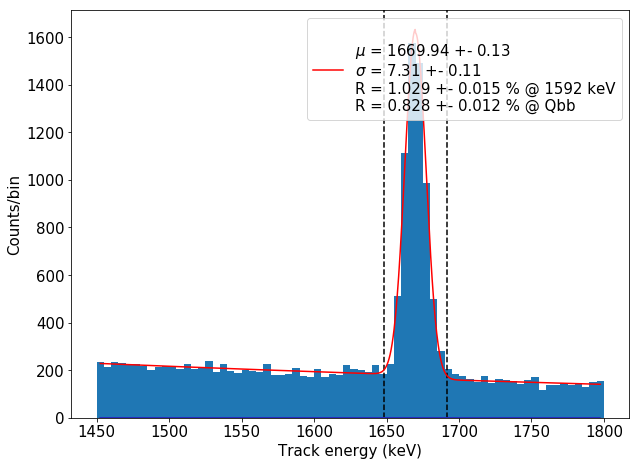

In [17]:
name   = 'Data_flatgauss_fixed_cut'
r_max  = 180 #180
zrange = [20, 510]
erange = [1450, 1800]
nbins  = 70
fixed  = fixed_const['Data_cut']
func   = flat_expo_and_gauss

filename = f'/home/lior/NEXT/Software/data/Lucy/beersheba/data/DECOjoint_Q{qcut:.0f}_I{it:.0f}_ECut{ecut:.3f}_ITHR0.00001_BIN1_INTERcubic/tracks/PaolinaAllTracks_Vox_{vox_size:.1f}_br{blobR:.1f}.h5'
data    = get_tracks(filename, r_max, zrange, erange, fMC=False)

#Original number
fit       = fit_data(data, nbins, erange, func, fixed_constant=fixed, fPlot=True)
sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])

ns, nb  = [sig], [bckg]
chi     = [fit.chi2]
fit_res = [fit]
thrs    = [0]

### Blob cut scan
nsteps = 100
estep  = 2*data.eblob1.mean() / nsteps
ejumps = range(1, nsteps+1)
for i in ejumps[:]:
    threshold = i*estep
    blob_cut  = data[data.eblob2 > threshold]
    try:
        fit = fit_data(blob_cut, nbins, erange, func, fixed_constant=fixed, fPlot=False)
        sig, bckg = count_signal_bckg(fit, np.diff(np.linspace(*erange, nbins+1))[0])
    except Exception as e:
        print(e)
        print(f'Dataset length = {len(blob_cut)}')
        break
    ns     .append(sig )
    nb     .append(bckg)
    fit_res.append(fit )
    thrs   . append(threshold)
    
ns, nb  = np.asarray(ns), np.asarray(nb)
fit_res = np.asarray(fit_res)
thrs    = np.asarray(thrs)

results_ns [name] = ns
results_nb [name] = nb
results_fit[name] = fit_res
results_thr[name] = thrs

### Results of data

Text(0, 0.5, 'f.o.m')

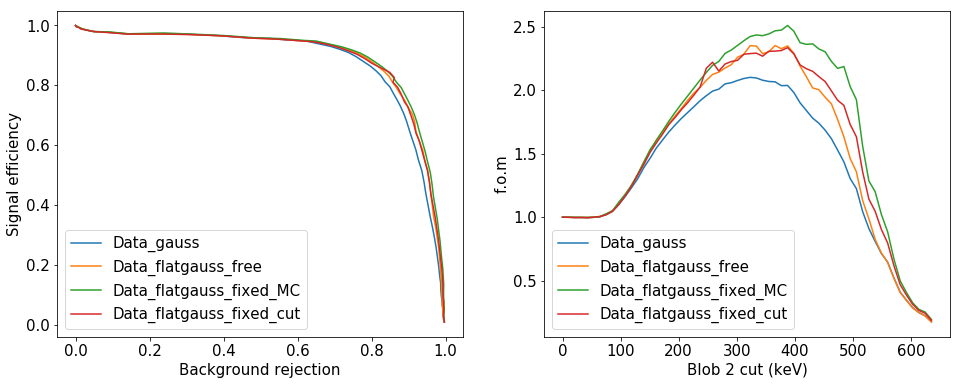

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name in list(results_nb.keys())[4:]:
    fom  = results_ns[name][:,0]/results_ns[name][0,0] / np.sqrt(results_nb[name][:,0]/(results_nb[name][0,0]))
    ethr = results_thr[name]
    sel  = fom<10
    axes[0].plot((1-results_nb[name][:,0]/(results_nb[name][0,0]))[sel], (results_ns[name][:,0]/results_ns[name][0,0])[sel], label=name)
    axes[1].plot(ethr[sel], fom[sel], label=name)
axes[0].legend()
axes[0].set_xlabel('Background rejection')
axes[0].set_ylabel('Signal efficiency'   )

axes[1].legend()
axes[1].set_xlabel('Blob 2 cut (keV)')
axes[1].set_ylabel('f.o.m'           )

### All results

Text(0, 0.5, 'f.o.m')

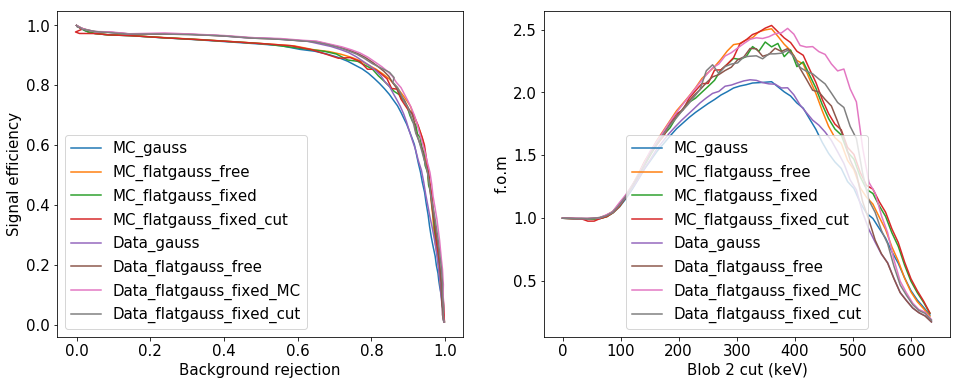

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for name in list(results_nb.keys())[:]:
    fom  = results_ns[name][:,0]/results_ns[name][0,0] / np.sqrt(results_nb[name][:,0]/(results_nb[name][0,0]))
    ethr = results_thr[name]
    sel  = fom<10
    axes[0].plot((1-results_nb[name][:,0]/(results_nb[name][0,0]))[sel], (results_ns[name][:,0]/results_ns[name][0,0])[sel], label=name)
    axes[1].plot(ethr[sel], fom[sel], label=name)
axes[0].legend()
axes[0].set_xlabel('Background rejection')
axes[0].set_ylabel('Signal efficiency'   )

axes[1].legend()
axes[1].set_xlabel('Blob 2 cut (keV)')
axes[1].set_ylabel('f.o.m'           )

### Constant comparison

Text(0, 0.0005984534274864923, 'High eff data')

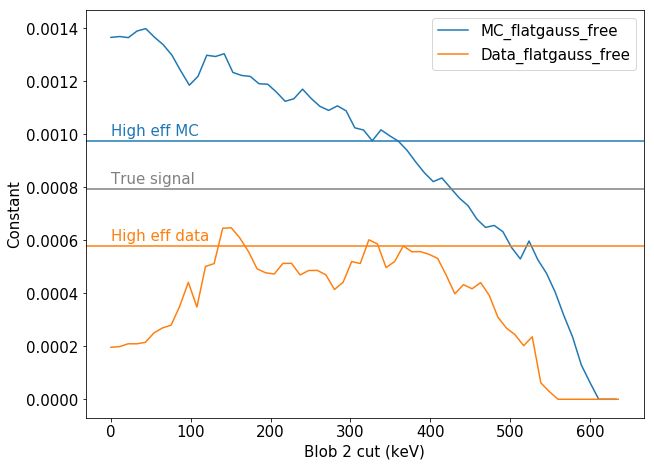

In [20]:
for name in ['MC_flatgauss_free', 'Data_flatgauss_free']:
    fit  = results_fit[name]
    ethr = results_thr[name]
    const = [f[1][-1] for f in fit]
    plt.plot(ethr, const, label=name)
plt.legend()
plt.xlabel('Blob 2 cut (keV)')
plt.ylabel('Constant'        )


plt.axhline(fixed_const['MC_signal'], c='gray')
plt.axhline(fixed_const['MC_cut'], c='C0')
plt.axhline(fixed_const['Data_cut'], c='C1')
plt.annotate('True signal'  , (0, fixed_const['MC_signal']+2e-5), color='gray')
plt.annotate('High eff MC'  , (0, fixed_const['MC_cut'   ]+2e-5), color='C0'  )
plt.annotate('High eff data', (0, fixed_const['Data_cut' ]+2e-5), color='C1'  )